In [1]:
# please make sure your drive_path is set, so that the notebook can find the data files on the hard drive

# OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/cell_types_cache/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# AWS
drive_path = '/data/dynamic-brain-workshop/cell_types_cache/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GLM_helpers import *
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input

from scipy.optimize import minimize

from allensdk.core.cell_types_cache import CellTypesCache

Using TensorFlow backend.


In [4]:
ctc = CellTypesCache(manifest_file=os.path.join(drive_path,'manifest.json'))

In [30]:
print cells.structure_area_abbrev.unique()

[u'VISp' u'VISl' u'VISpl' u'VISli' u'RSPagl' u'VISal' u'RSPd' u'TEa'
 u'SSp-tr' u'SSp-bfd' u'VISpm' u'VISa' u'VISpor' u'SSp-n' u'AUDpo' u'AUDp'
 u'VISam' u'VISrl' u'RSPv' u'SSp-un']


In [45]:
# pd.DataFrame(ctc.get_cells()).head()
cells = pd.DataFrame(ctc.get_cells(reporter_status='positive'))
print len(cells)
# cells.head()
# print cells.groupby(by='transgenic_line').size()
region = 'VISp'

inh_lines = []
exc_lines = []
exc_st = ['Rorb','Scnn','Nr5','Rbp','Emx','Cux','Tlx3','Sim1','Ntsr']
inh_st = ['Gad','Htr','Pvalb','Vip','Sst']
for line in cells.transgenic_line.unique():
    for st in exc_st:
        if line.startswith(st):
            exc_lines.append(line)
    for st in inh_st:
        if line.startswith(st):
            inh_lines.append(line)


has_line = False
# lines = ['Rorb-IRES2-Cre']
for line in inh_lines:
    has_line = has_line | (cells.transgenic_line==line)
inh_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(inh_cells)

for line in exc_lines:
    has_line = has_line | (cells.transgenic_line==line)
exc_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(exc_cells)

1813
1
1


In [6]:
#for cell in cell_types_class ...
epd = ctc.get_ephys_data(cells['id'][0])

In [6]:
names = []
for i in epd.get_experiment_sweep_numbers():
    names.append(epd.get_sweep_metadata(i)['aibs_stimulus_name'])
print np.unique(names)

[u'Long Square' u'Noise 1' u'Noise 2' u'Ramp' u'Short Square'
 u'Square - 0.5ms Subthreshold' u'Square - 2s Suprathreshold' u'Test']


In [7]:
def get_sweeps_with_stim(ephys_data,stim_type):
    sweeps = []
    for i in ephys_data.get_experiment_sweep_numbers():
        if str.startswith(str(ephys_data.get_sweep_metadata(i)['aibs_stimulus_name']),stim_type):
            sweep = ephys_data.get_sweep(i)
            sweep['spike_times'] = ephys_data.get_spike_times(i)
            sweeps.append(sweep)
    return sweeps

def bin_spikes_and_stim(sweeps,bin_len,zpad=0):
    spikes_list = []
    stim_list = []
    for sweep in sweeps:
        T = int(np.floor(sweep['index_range'][1]*1.0/(sweep['sampling_rate']*bin_len)))
        binned_spikes = np.zeros((1,T))
        binned_stim = np.empty((1,T))
        for spike_time in sweep['spike_times']:
            t = int(np.floor(spike_time/bin_len))
            binned_spikes[0,t]+=1
        for i in range(T):
            binned_stim[0,i] = np.mean(sweep['stimulus'][int(np.round(i*bin_len*sweep['sampling_rate'])):int(np.round((i+1)*bin_len*sweep['sampling_rate']))])
        spikes_list.append(binned_spikes)
        stim_list.append(binned_stim)
        if zpad>0:
            spikes_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
            stim_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
    binned_spikes = np.hstack(spikes_list)
    binned_stim = np.hstack(stim_list)
    return (binned_spikes, binned_stim)
        
    
    """
    - use stim kernel convolved with alpha function as prior for synapse
    """

In [216]:
# # Inputs:
# # stimulus: video shown to the mouse in some form
# # spikes: spikes recorded from each neuron in some form
# # link: string for the link function used. options are {'log', 'logit'}
# # priors: TODO
# # L1: regularization parameter for sparse synapses TODO

# # Returns:
# # GLM network model with parameters fit

# def GLM_network_fit(stimulus,spikes,d_stim, d_spk,link='log',priors=None,L1=None):
#     N = spikes.shape[0]
#     M = stimulus.shape[0]
#     K = np.empty((N,M,d_stim)) # stimulus filters
#     W = np.empty((N,N,d_spk))  # spike train filters
# #     b = np.empty((N,)) # biases
    
#     links = {'log':sm.genmod.families.links.log, 'logit':sm.genmod.families.links.logit}
#     for i in range(N):
#         [y, Xdsn] = construct_GLM_mat(stimulus,spikes,i, d_stim, d_spk)
#         y = y.reshape((-1,1))
#         # construct GLM model and return fit
#         if priors is None and L1 is None:
#             glm_pois = sm.GLM(y, Xdsn, family=sm.families.Poisson(link=links[link]))
#             gfit = glm_pois.fit()
#             p = gfit.params
#             K[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
#             W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
# #             W[i,:,:] = p[M*d_stim:-1].reshape((N,d_spk))
#             #             b[i] = p[-1]

#     return (K,W)
# #     return (K,W,b)



# Inputs
# flat_stimulus: M x T matrix of stimuli
# binned_spikes: N x T matrix of spike counts
# d_stim: duration of stimulus filter (# time bins)
# d_spk: duration of spike filters (# time bins)
def construct_GLM_mat(flat_stimulus, binned_spikes, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    X_dsn = np.empty((T-d_stim,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    for t in range(T-d_max):
        X_dsn[t,:M*d_stim] = np.fliplr(flat_stimulus[:,t+d_max-d_stim:t+d_max]).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d_stim:] = np.fliplr(binned_spikes[:,t+d_max-d_spk:t+d_max]).reshape((1,-1)) #spike inputs
    return X_dsn

In [209]:
sweeps = get_sweeps_with_stim(epd,'Noise')
bin_len = 0.0005
# bin_len = 0.005
i=0
# (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)

['stimulus', 'index_range', 'spike_times', 'stimulus_unit', 'sampling_rate', 'response']


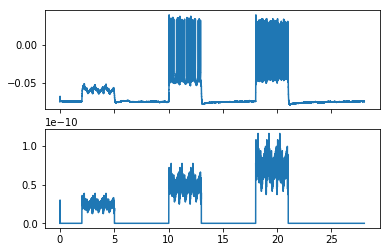

In [214]:

t = np.arange(0,sweeps[i]['index_range'][1]+1)*1.0/sweeps[i]['sampling_rate']
fig,ax = plt.subplots(2,1,sharex=True)
ax[1].plot(t,sweeps[i]['stimulus'])
ax[0].plot(t,sweeps[i]['response'])
# plt.xlim(10.3,10.31)
# print sweeps[5]['index_range']
# print sweeps[5]['sampling_rate']
print sweeps[0].keys()


In [ ]:
plt.plot(t,sweeps[i]['stimulus'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_stim))
plt.xlim([10.3,10.35])

(10.3, 10.5)

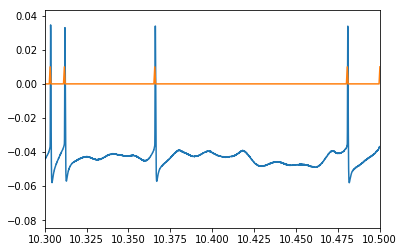

In [12]:
plt.plot(t,sweeps[i]['response'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_spikes)*0.01)
plt.xlim([10.3,10.5])

In [13]:
d = 50
(ydsn,Xdsn) = construct_GLM_mat(binned_stim*1e9, binned_spikes, i, d, d)
print Xdsn.shape
# plt.imshow(Xdsn[20900:21000],aspect=0.1)
# plt.plot(Xdsn[209090,:])

(336184, 100)


In [62]:
# from keras.engine.base_layer import Layer
# class FPrb(Layer):

#     def __init__(self,dt, **kwargs):
#         self.dt = dt
#         super(FPrb, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(input_shape[-1],1),
#                                       initializer='glorot_normal',
#                                       trainable=True)
#         self.built = True

#     def call(self, x):
#         return K.exp(K.dot(x, self.kernel))*self.dt
# #         return (K.dot(x, self.kernel))


#     def compute_output_shape(self, input_shape):
#         return (None,input_shape[0])

In [15]:
# def negloglikelihood(y_true,y_pred):
# #     return -(-y_pred+y_true*K.log(y_pred))
#     return -(-K.exp(y_pred)*1e-1+y_true*y_pred)



In [16]:
# def neglog_likelihood_poisson(theta, X, y):
#     return -np.dot(y.T,np.dot(X,theta)) + np.sum(np.exp(np.dot(X,theta))*1e-1)

# X = np.random.random([20000,30])
# beta = np.random.random([30, 1])*0.2
# w = np.exp(np.dot(X,beta))*0.1
# print np.max(w)
# y = np.random.poisson(lam=w, size=np.shape(w))
# myguess = np.random.normal(loc=0.0, scale= 1.0, size=np.shape(beta))
# print(np.shape(myguess))
# res = minimize(neglog_likelihood_poisson, args = (X,y), method = 'CG', x0 = myguess, options={'gtol':1e-14})
# plt.scatter(beta, res.x)

In [184]:
# inp = Input(shape=(Xdsn.shape[1],))
# out = FPrb(bin_len)(inp)
# model = Model(inputs = [inp], outputs = [out])
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=8e-2))

In [18]:
# from keras import Sequential
# from keras.layers import Dense, Lambda
# model = Sequential()
# model.add(Dense(1,input_dim = X.shape[1],use_bias=True))
# model.add(Lambda(lambda x: K.exp(x)*0.1))
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-3))
# model.fit(x=X,y=y,epochs=200,batch_size = 1000)

In [19]:
# print np.exp(model.get_weights()[1])
# plt.scatter(beta, model.get_weights()[0])

In [20]:
# from keras import Sequential
# from keras.layers import Dense, Lambda
# model = Sequential()
# model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
# model.add(Lambda(lambda x: K.exp(x)*bin_len))
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=2e-1))


In [185]:
# model.fit(x=Xdsn,y=ydsn,epochs=150,batch_size = 1000000)

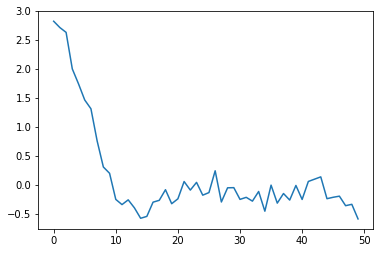

In [74]:
p = model.get_weights()[0]
# print np.exp(model.get_weights()[1])
plt.plot(p[:d])

In [8]:
def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,L1=None):
    N = spikes.shape[0]
    M = stimulus.shape[0]
    F = np.empty((N,M,d_stim)) # stimulus filters
    W = np.empty((N,N,d_spk))  # spike train filters
    b = np.empty((N,)) # biases
    fs = {'exp':K.exp}
    Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
    for i in range(N):
        y = spikes[i,max(d_stim,d_spk):]
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1.5e-1))
        model.fit(x=Xdsn,y=y,epochs=200,batch_size = 10000000,verbose=0)
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
        W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
        b[i] = model.get_weights()[1]
    return (F,W,b)

In [ ]:
(F,W,b) = GLM_network_fit(binned_stim*1e9,binned_spikes, d, d, bin_len)

[0.08559065]


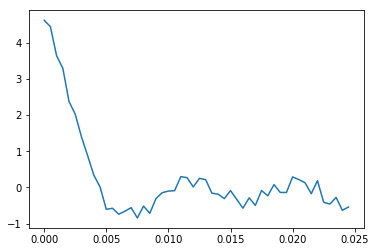

In [53]:
print np.exp(b)
plt.plot(np.arange(d)*bin_len,np.squeeze(F))

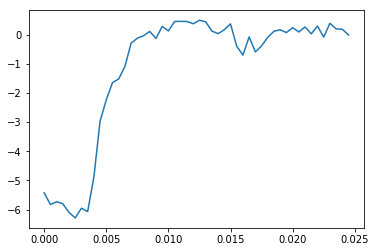

In [32]:
plt.plot(np.arange(d)*bin_len,np.squeeze(W))

In [79]:
# myguess = np.random.normal(loc=0.0, scale= 1.0, size=(Xdsn.shape[1],1))
# print(np.shape(myguess))
# res = minimize(log_likelihood_poisson, args = (Xdsn,y), method = 'CG', x0 = myguess, options={'gtol':1e-14})

In [169]:
# from keras.engine.base_layer import Layer
# class FPrb(Layer):

#     def __init__(self,t,num_exp=2, **kwargs):
#         self.dt = t[1]-t[0]
#         self.t = np.expand_dims(t,1)
#         self.T = len(t)
#         self.num_exp = num_exp
#         super(FPrb, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(2*self.num_exp*input_shape[1]/self.T+1,),   # [4p stim1, 4p stim2, ... , 4p spk1, 4p spk2,... ]
#                                       initializer='uniform',
#                                       trainable=True)
#         self.built = True

#     def call(self, x):
#         F = 0.0
#         for i in range(K.int_shape(self.kernel)[0]/(2*self.num_exp)):
# #             F += K.dot(x[:,i*self.T:(i+1)*self.T],self.kernel[i*2*self.num_exp]*K.exp(self.kernel[i*2*self.num_exp+1]*self.t)+self.kernel[i*4+2]*K.exp(self.kernel[i*4+3]*self.t))
#             for j in range(self.num_exp):
#                 F += K.dot(x[:,i*self.T:(i+1)*self.T],self.kernel[i*2*self.num_exp+j*2]*K.exp(self.kernel[i*2*self.num_exp+j*2+1]*self.t))
#         F+=self.kernel[-1]
#         return K.exp(F)*self.dt


#     def compute_output_shape(self, input_shape):
#         return (None,input_shape[0])

# inp = Input(shape=(Xdsn.shape[1],))
# out = FPrb(np.arange(d)*bin_len)(inp)
# model = Model(inputs = [inp], outputs = [out])
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-1))
# print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 100)               0         
_________________________________________________________________
f_prb_40 (FPrb)              (None, None)              9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x=Xdsn,y=ydsn,epochs=50,batch_size = 1000)

In [377]:
# t = np.arange(d)*bin_len
# # p = model.get_weights()[0]
# print np.exp(p[-1])
# print p
# w=0
# # plt.plot(t,p[2-w]*np.exp(p[3-w]*t))
# plt.plot(t,p[4-w]*np.exp(p[5-w]*t)+p[6-w]*np.exp(p[7-w]*t))

In [ ]:
bin_len = 0.001
d=30
t = np.arange(d)*bin_len
layers = np.unique(cells.structure_layer_name.values)
F_clumps = {}
W_clumps = {}
b_clumps = {}
for layer in layers:
    print layer
#     cell_ids = inh_cells[inh_cells.structure_layer_name==layer]['id'].values
    cell_ids = exc_cells[exc_cells.structure_layer_name==layer]['id'].values

    if len(cell_ids)>5:
        F_clump = []
        W_clump = []
        b_clump = []
        for i, cell_id in enumerate(cell_ids):
            print i, '/', len(cell_ids)
            sweeps = get_sweeps_with_stim(ctc.get_ephys_data(cell_id),'Noise')
            if len(sweeps)>0:
                (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
                (F,W,b) = GLM_network_fit(binned_stim*1e9,binned_spikes, d, d, bin_len)
                F_clump.append(np.squeeze(F))
                W_clump.append(np.squeeze(W))
                b_clump.append(np.squeeze(b))
                
        F_clumps[layer] = np.vstack(F_clump)
        W_clumps[layer] = np.vstack(W_clump)
        b_clumps[layer] = np.vstack(b_clump)


1
2/3
4
5
0 / 361
1 / 361
2 / 361
3 / 361
4 / 361
5 / 361
6 / 361
7 / 361
8 / 361
9 / 361
10 / 361
11 / 361
12 / 361
13 / 361
14 / 361
15 / 361
16 / 361
17 / 361
18 / 361
19 / 361
20 / 361
21 / 361
22 / 361
23 / 361
24 / 361
25 / 361
26 / 361
27 / 361
28 / 361
29 / 361
30 / 361
31 / 361
32 / 361
33 / 361
34 / 361
35 / 361
36 / 361
37 / 361
101 / 361
102 / 361
103 / 361
104 / 361
105 / 361
106 / 361
107 / 361
108 / 361
109 / 361
110 / 361
111 / 361
112 / 361
113 / 361
114 / 361
115 / 361
116 / 361
117 / 361
118 / 361
119 / 361
120 / 361
121 / 361
122 / 361
123 / 361
124 / 361
125 / 361
126 / 361
127 / 361
128 / 361
129 / 361
130 / 361
131 / 361
132 / 361
133 / 361
134 / 361
135 / 361
136 / 361
137 / 361
138 / 361
139 / 361
140 / 361
141 / 361
142 / 361
143 / 361
144 / 361
145 / 361
146 / 361
147 / 361
148 / 361
149 / 361
150 / 361
151 / 361
152 / 361
153 / 361
154 / 361
155 / 361
156 / 361
157 / 361
158 / 361
159 / 361
160 / 361
161 / 361
162 / 361
163 / 361
164 / 361
165 / 361
166 / 36

In [24]:
np.savez('inh_clumps',F_clumps_inh[lay],W_clumps_inh[lay],b_clumps_inh[lay])
# F_clumps_inh = F_clumps.copy()
# W_clumps_inh = W_clumps.copy()
# b_clumps_inh = b_clumps.copy()

<StemContainer object of 3 artists>

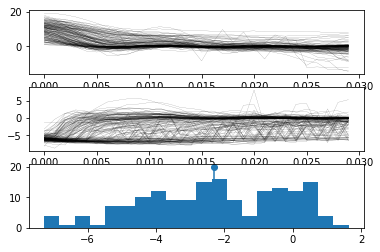

In [20]:
t = np.arange(d)*bin_len
lay = '5'
F_means = np.mean(F_clumps[lay],axis = 0)
W_means = np.mean(W_clumps[lay],axis = 0)
b_mean = np.mean(b_clumps[lay])

fig,ax = plt.subplots(3,1)
for i in range(b.shape[0]):
    ax[0].plot(t,F_clumps[lay].T,'k',linewidth = 0.1)
    ax[1].plot(t,W_clumps[lay].T,'k',linewidth = 0.1)
ax[0].plot(t,F_means,'k',linewidth = 0.1)
ax[1].plot(t,W_means,'k',linewidth = 0.1)
ax[2].hist(b_clumps[lay],bins = 20)
ax[2].stem([b_mean],[20])


(array([ 1.,  0.,  1.,  2., 26., 40., 45., 14., 11.,  7.,  7.,  2.,  1.,
         1.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([-8.74230099, -8.32319498, -7.90408898, -7.48498298, -7.06587697,
        -6.64677097, -6.22766497, -5.80855896, -5.38945296, -4.97034695,
        -4.55124095, -4.13213495, -3.71302894, -3.29392294, -2.87481694,
        -2.45571093, -2.03660493, -1.61749893, -1.19839292, -0.77928692,
        -0.36018091]),
 <a list of 20 Patch objects>)

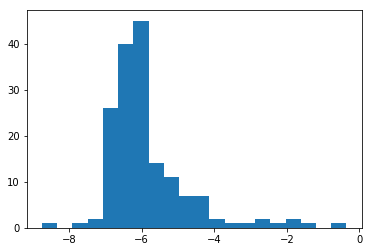

In [18]:
i = 1
plt.hist(W_clumps[lay][:,i],bins=20)

In [242]:
# def GLM_network_fit_exps(stimulus,spikes,d_stim, d_spk,bin_len,num_exp=2,f='exp',priors=None,L1=None):
#     N = spikes.shape[0]
#     M = stimulus.shape[0]
#     F = np.empty((N,M,num_exp*2)) # stimulus filters
#     W = np.empty((N,N,num_exp*2))  # spike train filters
#     b = np.empty((N,)) # biases
#     fs = {'exp':K.exp}
#     Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
#     for i in range(N):
#         y = spikes[i,max(d_stim,d_spk):]
#         # construct GLM model and return fit
#         inp = Input(shape=(Xdsn.shape[1],))
#         out = FPrb(np.arange(d)*bin_len,num_exp=num_exp)(inp)
#         model = Model(inputs = [inp], outputs = [out])
#         model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-2))
#         model.fit(x=Xdsn,y=y,epochs=200,batch_size = 1000,verbose=0)
#         p = model.get_weights()[0]
#         F[i,:,:] = p[:M*num_exp*2].reshape((M,num_exp*2))
#         W[i,:,:] = p[M*num_exp*2:-1].reshape((N,num_exp*2))
#         b[i] = p[-1]
#     return (F,W,b)

In [ ]:
# fig,ax = plt.subplots(2,1)
# for spec_id in inh_cells['id'].values[1:2]:
#     print spec_id
#     sweeps = get_sweeps_with_stim(ctc.get_ephys_data(spec_id),'Noise')
#     if len(sweeps)>0:
#         (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
#         (F,W,b) = GLM_network_fit_exps(binned_stim*1e9,binned_spikes, d, d, bin_len)
#         F = np.squeeze(F)
#         W = np.squeeze(W)
#         print F,W,b
#         ax[0].plot(t,F[0]*np.exp(F[1]*t)+F[2]*np.exp(F[3]*t))
#         ax[1].plot(t,W[0]*np.exp(W[1]*t)+W[2]*np.exp(W[3]*t))

In [248]:
# from scipy.optimize import differential_evolution

# def EvalExpFit(x, a, b):
#     return np.dot(a, np.exp(-np.outer(b, x)))

# def ExpFitDiffEvol(N, x, y):
#     """Fit N-exponential decay to a dataseries (x, y) using differential
#     evolution as implemented in scipy.optimize.
#     Parameters
#     ----------
#     N : float
#         number of summed exponentials to fit
#     x : array
#         x values
#     y : array
#         y values
#         returns a, b
#         len(a) = N
#         len(b) = N
#         y(x) = \sum_{i=1}^N a_i \exp ( - b_i x )
#         Use of differntial evolution inspired by use of another genetic algorithm
#         to perform exponential fit of by Weizhong Zou in
            
#             Zou, Weizhong. Larson, Ronald G.
#             "A mesoscopic simulation method for predicting the rheology of
#             semi-dilute wormlike micellar solutions." Journal of Rheology. 58,
#             681 (2014).
#     """
#     x = np.array(x)
#     y = np.array(y)

#     bounds = [[min(x), max(x)]]*N + [[min(y), max(y)]]*N

#     def objective(s):
#         taui, fi = np.split(s, 2)
#         return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2.)

#     result = differential_evolution(objective, bounds)
#     s = result['x']
#     taui, fi = np.split(s, 2)
#     return fi, 1./taui

In [ ]:
# nexp = 5
# W_fir = np.squeeze(W_fir)
# fit_inds = range(np.argmax(np.diff(W_fir)),W_fir.shape[0]-1)
# fit_inds.extend(range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2))
# fit_inds.extend(range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2))

# # fit_inds = range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2)
# # fit_inds.append(W_fir.shape[0]-1)
# print fit_inds
# (a,b) = ExpFitDiffEvol(nexp,t[fit_inds],W_fir[fit_inds])
# print a, b
# # a = [10,-30]
# # b = [350,900]
# # a = [-7.06*3,3.3]
# # b = [938,159]

# # plt.plot(t[fit_inds],EvalExpFit(t[fit_inds],a,b))
# # plt.plot(t[fit_inds],W_fir[fit_inds])
# plt.plot(t,EvalExpFit(t,a,b))
# plt.plot(t,W_fir)

In [ ]:
# plt.plot(np.hstack([1*np.ones((5,1)),2*np.ones((5,1)),3*np.ones((5,1)),4*np.ones((5,1))]))
# print bin_len